Задачи:
* Добавление классов в датасет
* Оценка показателей классификации
* Анализ ошибок классификатора
* Дополнение обучения классификации аугментациями https://albumentations.ai/
* Дополнение вывода метрик при обучении в Tensorboard train: loss, valid: calssification metrics (по каждому классу и усредненные по macro), loss, а также lr


Инклудим все подряд, потому что можем

In [1]:
import albumentations as A
if A.__version__ != '1.0.3':
    !pip install albumentations==1.0.3
    !pip install opencv-python-headless==4.5.2.52
    assert False, 'restart runtime pls'

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL
import cv2
from datetime import datetime

CURRENT_FILE_NAME = '1_0_ClassifierResearch.ipynb'

%cd adas_system/notebooks

IN_COLAB = False
USE_COLAB_GPU = False
try:
    import google.colab
    IN_COLAB = True
    USE_COLAB_GPU = True
    from google.colab import drive
    drive.mount('/content/drive')
    if not os.path.isfile(CURRENT_FILE_NAME):
        !git clone --branch 9_SignDetector https://github.com/lsd-maddrive/adas_system.git

    if not os.path.isdir('../data'):
        !gdown --id 1-K3ee1NbMmx_0T5uwMesStmKnZO_6mWi
        !gdown --id 1-l3VvU-WtSoXbW_AaTFUreVD-tgXV8Q0
        %cd adas_system/notebooks
        !mkdir ../data/R_MERGED
        !unzip -q -o /content/R_MERGED.zip -d ./../data/
        !unzip -q -o /content/STOCK_SIGNS.zip -d ./../data/
except:
    if IN_COLAB:
        print('[!]YOU ARE IN COLAB, BUT DIDNT MOUND A DRIVE. Model wont be synced[!]')

        if not os.path.isfile(CURRENT_FILE_NAME):
            !git clone --branch 9_SignDetector https://github.com/lsd-maddrive/adas_system.git
            !gdown --id 1-K3ee1NbMmx_0T5uwMesStmKnZO_6mWi
            !gdown --id 1-l3VvU-WtSoXbW_AaTFUreVD-tgXV8Q0
            %cd adas_system/notebooks
            !mkdir ../data/R_MERGED
            !unzip -q -o /content/R_MERGED.zip -d ./../data/
            !unzip -q -o /content/STOCK_SIGNS.zip -d ./../data/

        IN_COLAB = False

    else:
        pass

###
import nt_helper
from nt_helper.helper_utils import *
###

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
%matplotlib inline
plt.rcParams["figure.figsize"] = (17,10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[WinError 3] The system cannot find the path specified: 'adas_system/notebooks'
D:\d_tsw\1_SIGN_CLASSIFIER\notebooks
helper init success


device(type='cuda')

In [2]:
if not IN_COLAB:
    PROJECT_ROOT = pathlib.Path(os.path.join(os.curdir, os.pardir))
else:
    PROJECT_ROOT = pathlib.Path('..')
    
DATA_DIR = PROJECT_ROOT / 'data'
NOTEBOOKS_DIR = PROJECT_ROOT / 'notebooks'

1. Добавить инфы в датасет. 

> RTSD Public не содержит 14 необходимых знаков: 1.6, 1.31, 2.4, 3.21, 3.22, 3.23. 3.24 (90, 100, 110, 120, 130), 3.25, 3.31, 6.3.2.

| Знак | Описание | Источник |
| ------------- | ------------- | ---- |
| 1.6 | Пересечение равнозначных дорог | - |
| 1.31 | Туннель | - |
| 2.4 | Уступите дорогу | GTSRB Recognition |
| 3.21 | Конец запрещения обгона | GTSRB Recognition |
| 3.22 | Обгон грузовым автомобилям запрещен | GTSRB Recognition |
| 3.23 | Конец запрещения обгона грузовым автомобилям | GTSRB Recognition |
| 3.24-90 | Огр 90 | - |
| 3.24-100 | Огр 100 | GTSRB Recognition |
| 3.24-110 | Огр 110 | - |
| 3.24-120 | Огр 120 | GTSRB Recognition |
| 3.24-130 | Огр 130 | - |
| 3.25 | Конец огр. максимальной скорости | GTSRB Recognition |
| 3.31 | Конец всех ограничений | GTSRB Recognition |
| 6.3.2 | Зона для разворота | - |


Идея: берем стандартные изображения знаков, обучаем классификатор на них

In [3]:
# import pandas as pd
# import os
# import pathlib
# import shutil
# import numpy as np

STOCK_SIGNS_CSV_LOCATION = DATA_DIR / 'STOCK_SIGNS.csv'
STOCK_SIGNS_DATAFRAME = pd.read_csv(STOCK_SIGNS_CSV_LOCATION)
# PREFIX = 'STOCK_SIGNS\\'
# STOCK_SIGNS_DIR = pathlib.Path('D:\\d_tsw\\1_SIGN_CLASSIFIER\\data\\STOCK_SIGNS')
# STOCK_SIGNS_LIST = os.listdir(STOCK_SIGNS_DIR)

# STOCK_SIGNS_DATAFRAME = pd.DataFrame(columns=['filepath', 'SIGN'])
# for sign in STOCK_SIGNS_LIST:
#     sign_as_series = pd.DataFrame(data=[[PREFIX + sign, '.'.join(sign.split('.')[:-1])]], 
#                                   columns=STOCK_SIGNS_DATAFRAME.columns
#                                  )
#     STOCK_SIGNS_DATAFRAME = STOCK_SIGNS_DATAFRAME.append(sign_as_series, ignore_index=True)

# STOCK_SIGNS_DATAFRAME.to_csv(STOCK_SIGNS_CSV_LOCATION, index=False)

### FIX 5.19.2
STOCK_SIGNS_DATAFRAME.loc[STOCK_SIGNS_DATAFRAME['SIGN'] == '5.19.2', 'SIGN'] = '5.19.1'
### /FIX 5.19.2
STOCK_SIGNS_DATAFRAME[::6]

,filepath,SIGN
0,STOCK_SIGNS\1.1.png,1.1
6,STOCK_SIGNS\2.1.png,2.1
12,STOCK_SIGNS\3.18.1.png,3.18.1
18,STOCK_SIGNS\3.24.100.png,3.24.100
24,STOCK_SIGNS\3.24.40.png,3.24.40
30,STOCK_SIGNS\3.25.10.png,3.25.10
36,STOCK_SIGNS\3.25.30.png,3.25.30
42,STOCK_SIGNS\3.25.90.png,3.25.90
48,STOCK_SIGNS\5.16.png,5.16
54,STOCK_SIGNS\6.3.2.png,6.3.2


In [4]:
from sklearn import preprocessing

LE_LOCATION = DATA_DIR / 'STOCK_SIGNS_LE.npy'
le = preprocessing.LabelEncoder()

if os.path.isfile(LE_LOCATION):
    le.classes_ = np.load(LE_LOCATION, allow_pickle=True)
else:
    le.fit_transform(STOCK_SIGNS_DATAFRAME['SIGN'])
    np.save(LE_LOCATION, le.classes_)

STOCK_SIGNS_DATAFRAME['ENCODED_LABELS'] = le.transform(STOCK_SIGNS_DATAFRAME['SIGN'])
STOCK_SIGNS_DATAFRAME['filepath'] = STOCK_SIGNS_DATAFRAME['filepath'].apply(lambda x: str(x).replace('\\', '/'))
STOCK_SIGNS_DATAFRAME['filepath'] = STOCK_SIGNS_DATAFRAME['filepath'].apply(lambda x: DATA_DIR / x)
STOCK_SIGNS_DATAFRAME[::6]

,filepath,SIGN,ENCODED_LABELS
0,..\data\STOCK_SIGNS\1.1.png,1.1,0
6,..\data\STOCK_SIGNS\2.1.png,2.1,6
12,..\data\STOCK_SIGNS\3.18.1.png,3.18.1,12
18,..\data\STOCK_SIGNS\3.24.100.png,3.24.100,18
24,..\data\STOCK_SIGNS\3.24.40.png,3.24.40,24
30,..\data\STOCK_SIGNS\3.25.10.png,3.25.10,30
36,..\data\STOCK_SIGNS\3.25.30.png,3.25.30,36
42,..\data\STOCK_SIGNS\3.25.90.png,3.25.90,42
48,..\data\STOCK_SIGNS\5.16.png,5.16,48
54,..\data\STOCK_SIGNS\6.3.2.png,6.3.2,53


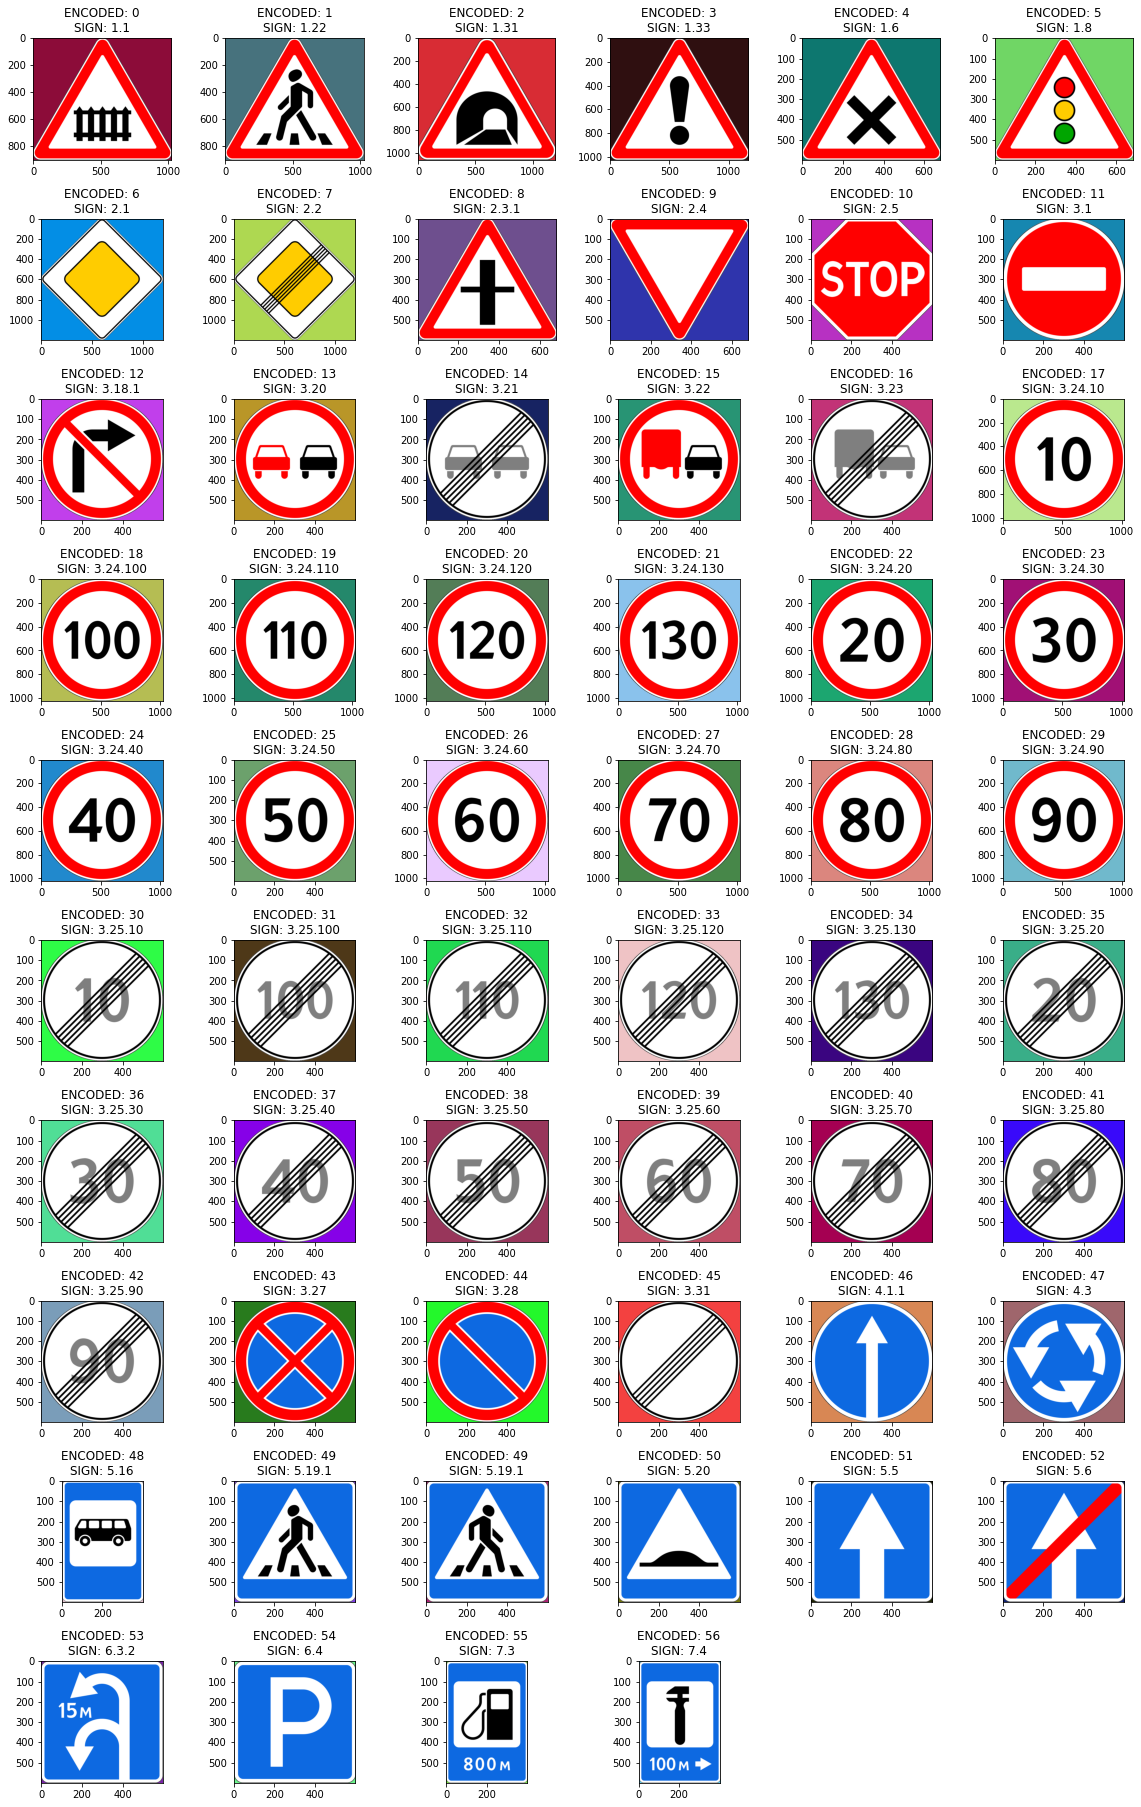

In [5]:
SIGN_LIST = list(STOCK_SIGNS_DATAFRAME['SIGN'])

nrows, ncols = 20, 6
fig = plt.figure(figsize = (16,50))

# for idx, sign_class in enumerate(STOCK_SIGNS_DATAFRAME['SIGN']):
for idx, row in enumerate(STOCK_SIGNS_DATAFRAME.iterrows()):
    instance = row[1]
    # print(instance)
    # instance = STOCK_SIGNS_DATAFRAME[STOCK_SIGNS_DATAFRAME['SIGN'] == sign_class].iloc[-1]
    path = str(instance['filepath'])
    sign = instance['SIGN']
    encoded_label = instance['ENCODED_LABELS']
    
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    trans_mask = img[:,:,3] == 0
    img[trans_mask] = [random.randrange(0, 256), random.randrange(0, 256), random.randrange(0, 256), 255]
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    ax = fig.add_subplot(nrows, ncols, idx+1)
    
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect=1)
    ax.set_title('ENCODED: ' + str(encoded_label) 
                 + '\nSIGN: ' + str(sign)
                )
    
plt.tight_layout()

Создадим загрузчик с аугментацией

In [6]:
class SignDataset(torch.utils.data.Dataset):
    def __init__(self, df, set_label=None, img_size=32, hyp=None, transform=None, le=None):
        
        if isinstance(img_size, int):
            img_size = (img_size, img_size)
        self.img_size = img_size
        
        self.transform = transform
        
        if set_label == None:
            self.df = df
        else:
            self.df = df[df['SET']==set_label]
        
        self.hyp = hyp

    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, index): 
        label = int(self.df.iloc[index]['ENCODED_LABELS'])
        path = str(self.df.iloc[index]['filepath'])
        
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        # check does it contains transparent channel 
        if img.shape[2] == 4:
        # randomize transparent
            trans_mask = img[:,:,3] == 0
            img[trans_mask] = [random.randrange(0, 256), 
                               random.randrange(0, 256), 
                               random.randrange(0, 256), 
                               255]

            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        # /randomize transparent
        
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_LANCZOS4)
        
        # augment
        if self.transform:
            img = self.transform(image=img)['image']
            
        if self.hyp and self.transform:
            img, _ =  random_perspective(img, 
                                      (),
                                      degrees=self.hyp['degrees'],
                                      translate=self.hyp['translate'],
                                      scale=self.hyp['scale'],
                                      shear=self.hyp['shear'],
                                      perspective=self.hyp['perspective'],
                                      border=self.hyp['border'])
        
        # /augment
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_LANCZOS4)
        
        img_tnsr = torch.Tensor.permute(torch.Tensor(img), [2, 0, 1]).div(255)
        return img_tnsr, label

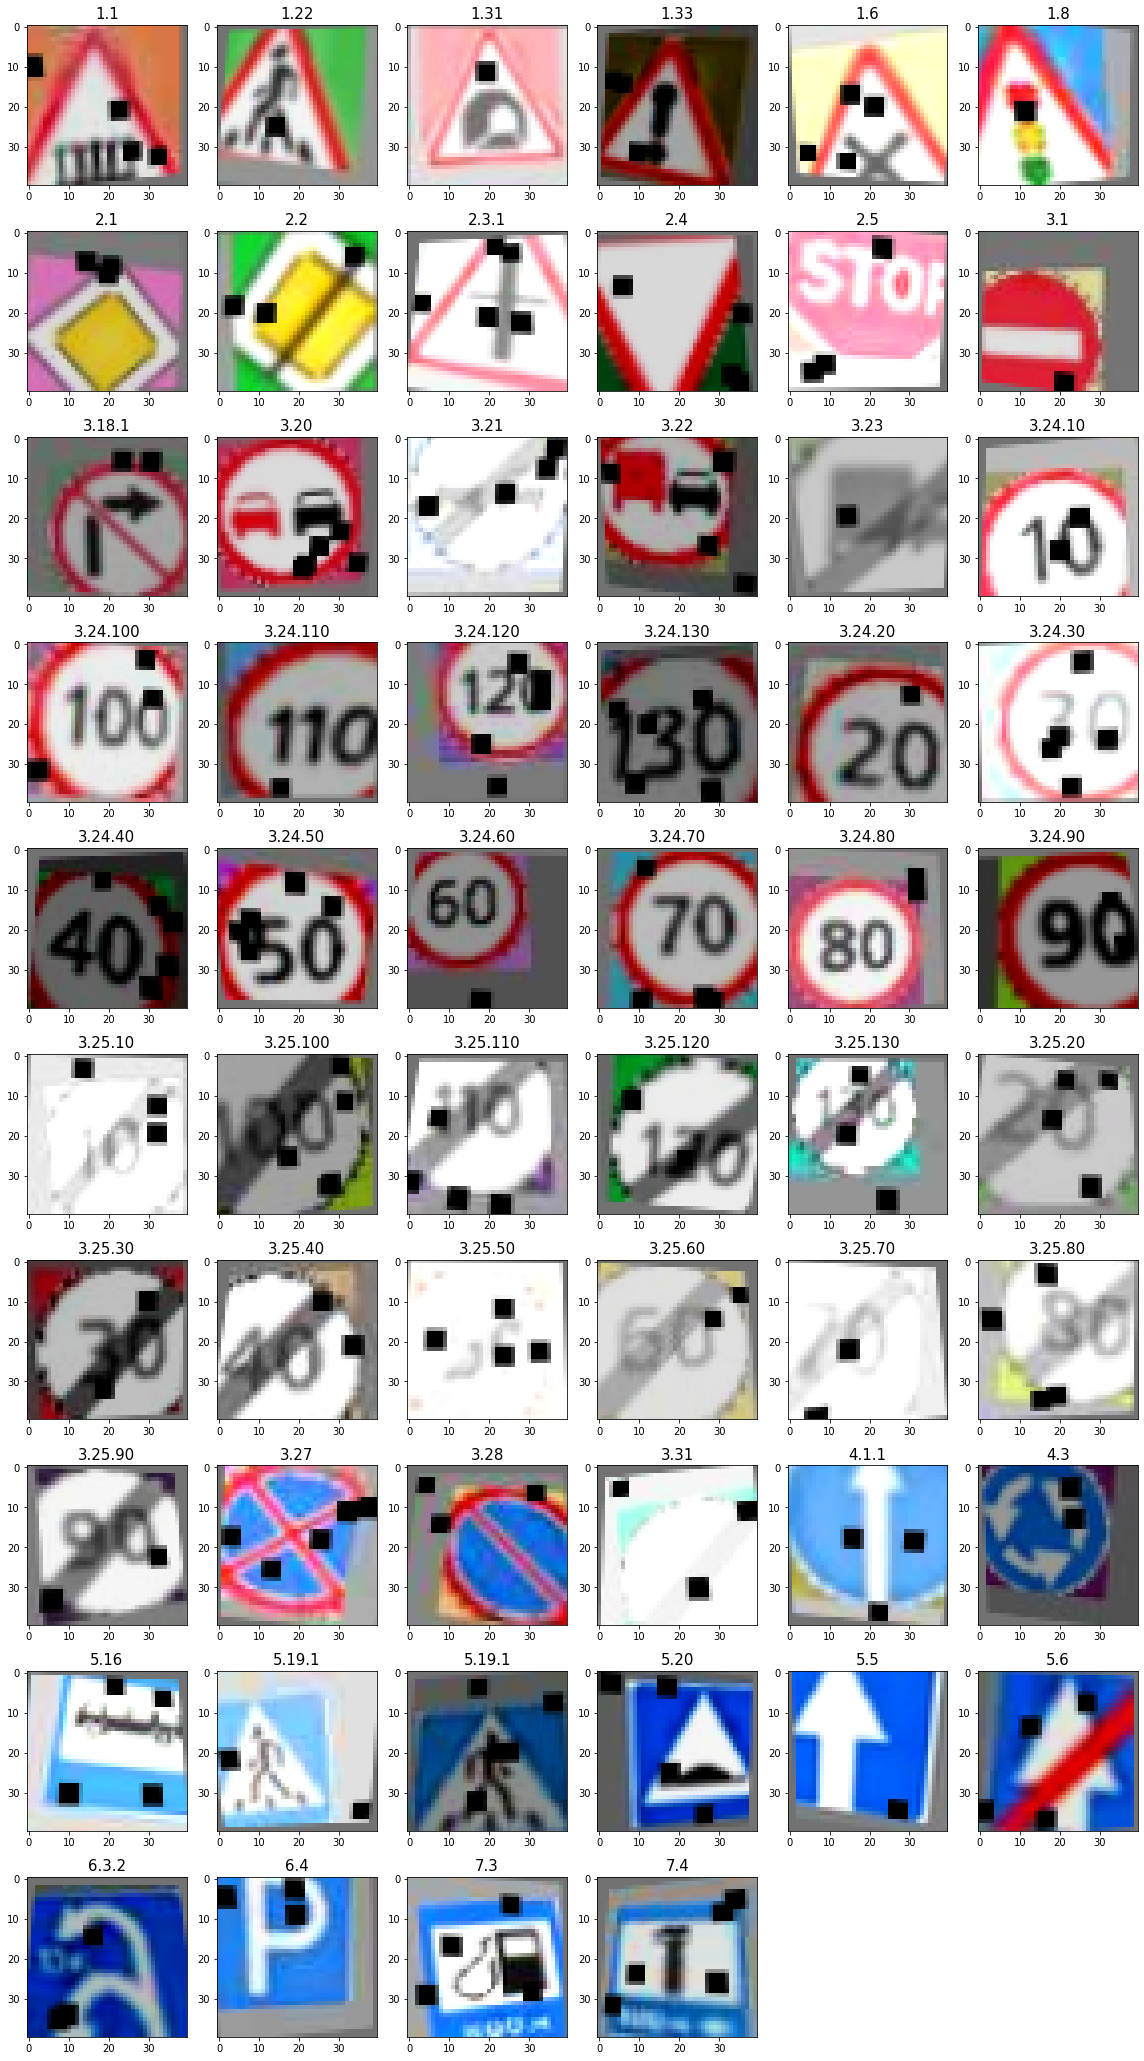

In [30]:
from albumentations.augmentations.geometric.transforms import Perspective, ShiftScaleRotate
img_size = 40

transform = A.Compose([
    # A.RandomCrop(p=0.2, width=int(img_size*0.9), height=int(img_size*0.9)),
    A.Blur(blur_limit=2),
    A.CLAHE(p=1),
    # A.Blur(blur_limit=1),
    # A.MotionBlur(),
    # A.ElasticTransform(p=1),
    A.Perspective(scale=(0.01, 0.1), p=1), 
    # A.MedianBlur(blur_limit=1),
    # A.ToGray(p=0.05),
    A.ShiftScaleRotate(shift_limit=0.2,
                       scale_limit=0.2,
                       interpolation=cv2.INTER_LANCZOS4, 
                       border_mode=cv2.BORDER_CONSTANT, 
                       value=(144,144,144),
                       rotate_limit=6, p=1),
    A.RandomGamma(
        gamma_limit=(50, 130), 
        p=1
    ),
    A.ImageCompression(quality_lower=30, p=1),
    A.RandomBrightnessContrast(brightness_limit=0.5, 
                               contrast_limit=0.3, 
                               brightness_by_max=False, 
                               p=1),
    A.CoarseDropout(max_height=5, 
                    max_width=5, 
                    min_holes=1, 
                    max_holes=5, 
                    p=1),
    # A.Cutout(num_holes=3, p=0.5),
    ]
)

hyp = {
    'degrees': 2,
    'translate': 0.01,
    'scale': 0,
    'shear': 2,
    'perspective': 0.0055,
    'border': (0, 0)
}

train_dataset = SignDataset(STOCK_SIGNS_DATAFRAME, 
                            set_label=None, 
                            img_size=img_size, 
                            transform=transform, 
                            hyp=hyp)
# train_dataset[0]
nrows, ncols = 70, 6
fig = plt.figure(figsize = (16,200))

for idx, (img, encoded_label) in enumerate(train_dataset):
    
    img = torch.Tensor.permute(img, [1, 2, 0]).numpy() 
    ax = fig.add_subplot(nrows, ncols, idx+1)
        
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect=1)
    ax.set_title(str(le.inverse_transform([encoded_label])[0]), fontsize=15)
    
plt.tight_layout()

Тренимся только на этом датасете. Валидационный возьмем gt.

In [42]:
gt = pd.read_csv(DATA_DIR / 'RTDS_DATASET.csv')
NUMBER_TO_SIGN = pd.read_csv(DATA_DIR / 'number_to_sign.csv', index_col=0).T.to_dict('records')[0]

gt['SIGN'] = gt['SIGN'].apply(lambda x: NUMBER_TO_SIGN[x].replace('_', '.').replace('n', ''))
gt['filepath'] = gt['filepath'].apply(lambda x: DATA_DIR / x)
gt.loc[gt['SIGN'] == '2.3', 'SIGN'] = '2.3.1'
gt.loc[gt['SIGN'] == '3.18', 'SIGN'] = '3.18.1'

gt['ENCODED_LABELS'] = le.transform(gt['SIGN'])

# UNFIX TRAIN
gt.drop_duplicates(subset='filepath', inplace=True)

GT_SIGNS_SET  = set(gt['SIGN'])
STOCK_SIGNS_SET = set(STOCK_SIGNS_DATAFRAME['SIGN'])

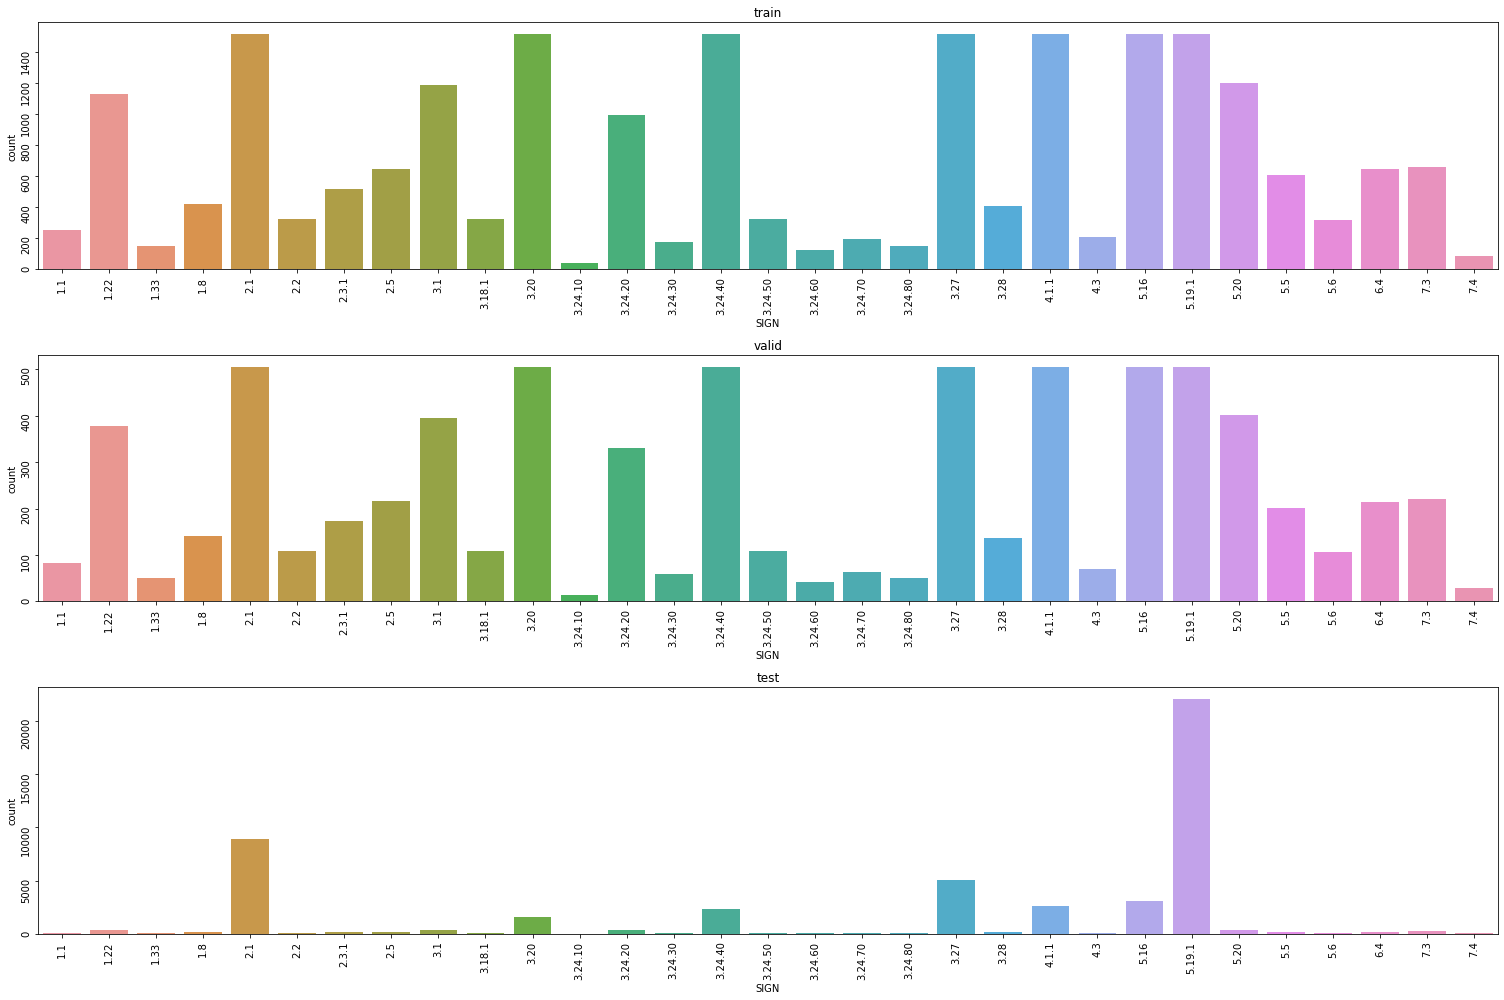

In [43]:
_, ax = plt.subplots(nrows=3, ncols=1, figsize=(21, 14))

LABELS = ['train', 'valid', 'test']

for i in range(len(LABELS)):
    g = sns.countplot(x='SIGN', 
                      data=gt[gt['SET']==LABELS[i]],  
                      ax=ax[i], 
                      order=sorted(gt['SIGN'].value_counts().index.tolist())
                     )
    ax[i].tick_params(labelrotation=90)
    ax[i].set_title(LABELS[i])
    plt.tight_layout()

Уменьшим валидационный набор

In [44]:
FIX_VALID = False
minimal_valid_sign_count = None

if FIX_VALID:
    temp_gt = pd.DataFrame(columns=gt.columns)
    print('[+] FIX VALID TRUE')
    minimal_valid_sign_count = min(gt[gt['SET'] == 'valid'].groupby(['SIGN']).size())

    for sign_label in GT_SIGNS_SET:
        # print(gt[gt['SIGN'] == sign_label])
        gt_part = gt.loc[(gt['SIGN'] == sign_label) & (gt['SET'] == 'valid')]
        delta = len(gt_part.index) - minimal_valid_sign_count
        drop_indices = np.random.choice(gt_part.index, delta, replace=False)
        gt_part = gt_part.drop(drop_indices)
        temp_gt = temp_gt.append(gt_part)
        
    gt = temp_gt
else:
    print('[!] FIX VALID FALSE')
    minimal_valid_sign_count = min(gt.groupby(['SIGN']).size())
    
minimal_valid_sign_count

[!] FIX VALID FALSE


64

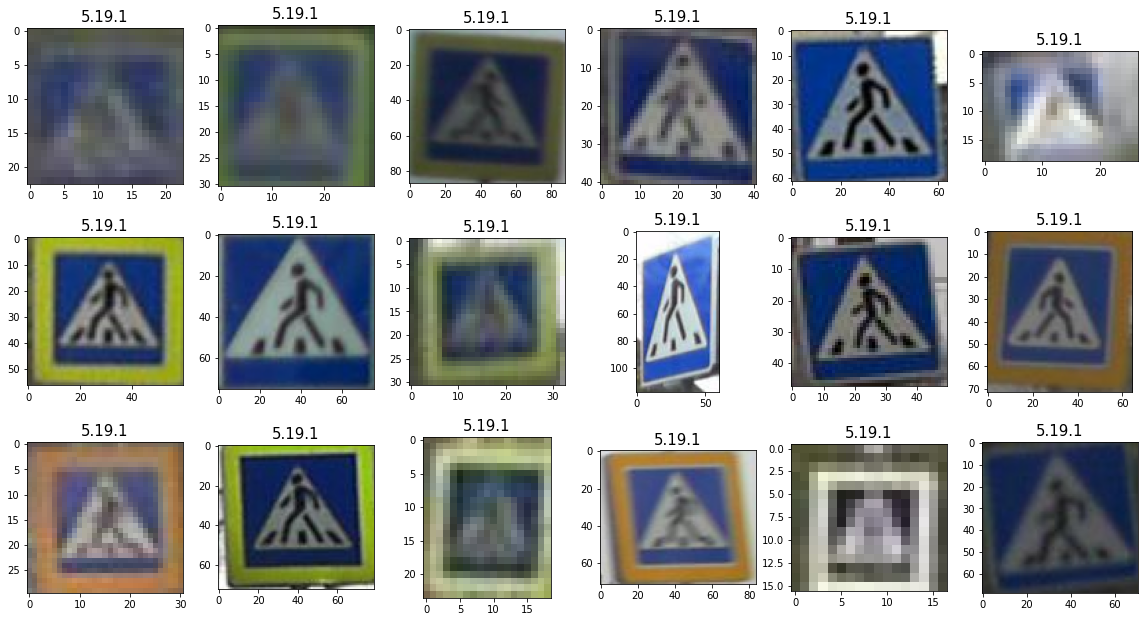

In [45]:
IMG_COUNT = 18
nrows, ncols = 70, 6
fig = plt.figure(figsize = (16,200))

label = '5.19.1'

temp_gt = gt.loc[gt['SIGN'] == label]
temp_gt = temp_gt.sample(min(minimal_valid_sign_count, IMG_COUNT))
for idx, (_, row) in enumerate(temp_gt.iterrows()):
    img = cv2.imread(str(row['filepath']))
        
    ax = fig.add_subplot(nrows, ncols, idx+1)

    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect=1)
    ax.set_title(label, fontsize=15)
    
plt.tight_layout()

In [46]:
print(GT_SIGNS_SET.difference(STOCK_SIGNS_SET))

set()


STOCK_SIGNS_SET.difference(GT_SIGNS_SET) - пустой, т.к. пак дефолтных изображений содержит всех представителей знаков RTDS.

In [47]:
valid_dataset = SignDataset(gt, 
                            set_label=None,
                            img_size=img_size
                           )

num_workers=0
if IN_COLAB or USE_COLAB_GPU:
    num_workers=2

batch_size = 260
if IN_COLAB or USE_COLAB_GPU:
    batch_size = 2500
    
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False)

valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False)

In [48]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm, trange
import torchvision

def train_epoch(model, loader, loss_op, optim, device, writer=None):

    model.train()
    model.to(device)
    
    losses = 0
    rights = 0
    pbar = tqdm(enumerate(loader),
                total=len(loader), 
                position=0,
                leave=False)
    
    for idx, (data, target) in pbar:
                    
        data = data.to(device)
        target = target.to(device)

        optim.zero_grad()
        pred = model(data)

        iter_right_count = get_rights_count(pred, target).cpu().numpy()
        rights += iter_right_count
        
        loss = loss_op(pred, target)
        losses += loss.item()
        
        # Gradient descent
        loss.backward()
        optim.step()
        
        #if writer:
        #    grid = torchvision.utils.make_grid(data)
        #    writer.add_image('images', grid, 0)
        #    writer.add_graph(model, data)
            
        pbar.set_description("TRAIN: INSTANT LOSS %f INSTANT ACCUR: %.4f" % 
                             (round(loss.item() / len(target), 3), 
                              iter_right_count / len(target))
                            )
        
    return losses

def get_rights_count(y_pred, y_true):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_true).float()
    acc = correct_pred.sum()
    return acc

@torch.no_grad()
def valid_epoch(model, loader, device):
    
    model.eval()
    model.to(device)
    
    rights = 0
    pbar = tqdm(enumerate(loader),
                total=len(loader),
                position=0,
                leave=False)
        
    for idx, (data, target) in pbar:
        data = data.to(device)
            
        target = target.to(device)
        pred = model(data)

        iter_right_count = get_rights_count(pred, target).cpu().numpy()
        rights += iter_right_count
        
        pbar.set_description("VALIDATION: INSTANT ACCUR: %.4f" % (iter_right_count / len(target)))
        
    return rights / len(loader.dataset)

In [49]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir runs (started 1:12:23 ago; pid 2056)


In [50]:
%reload_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/classifier')
%tensorboard --logdir runs --host=127.0.0.1
print('tensorboard initiated')

Reusing TensorBoard on port 6006 (pid 2056), started 1:12:24 ago. (Use '!kill 2056' to kill it.)

tensorboard initiated


In [51]:
from torchvision import models

# DEFAULT_MODEL_LOCATION = DATA_DIR / 'CLASSIFIER_ON_STOCK'
CHECKPOINT_LOCATION = DATA_DIR / 'classifier_check_point'

config = {
    'lr': 0.1,
    'epochs': 6000,
    'momentum':  0.937,
}

started_epoch = 0

model = models.resnet18(pretrained=True)
MODEL_CLASSES = len(STOCK_SIGNS_SET)
model.fc = nn.Sequential(
    nn.Linear(512, MODEL_CLASSES),
)

model.to(device)

optim = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], nesterov=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optim, 
                                              base_lr=0.00001, 
                                              max_lr=config['lr'],
                                              step_size_up=40,
                                              step_size_down=120,
                                              mode="exp_range",
                                              gamma=0.2
                                            )
loss_op = nn.CrossEntropyLoss()

def saveCheckpoint(model, scheduler, optimizer, epoch, filename):
    torch.save({
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
    }, filename)

def loadCheckpoint(model, scheduler, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

try:
    model, optim, scheduler, started_epoch = loadCheckpoint(model, scheduler, optim, CHECKPOINT_LOCATION)
    print('[+] checkpoint loaded')
except:
    print('[!] checkpoint doesnt exist')


#scheduler = torch.optim.lr_scheduler.CyclicLR(optim, 
#                                              base_lr=0.00001, 
#                                              max_lr=config['lr'],
#                                              step_size_up=40,
#                                              step_size_down=120,
#                                              mode="exp_range",
#                                              gamma=0.995
#                                            )
model.eval()    

loss_op.to(device)

print(':)')

[+] checkpoint loaded
:)


In [52]:
started_epoch

2549

In [21]:
SHOULD_I_TRAIN = False

from utils.general import one_cycle
from torch.optim import lr_scheduler

i = 0
ACC_THRES = 0.8

if SHOULD_I_TRAIN:
    pbar = trange(
        started_epoch, 
        config['epochs'], 
        initial=started_epoch, 
        total=config['epochs'],
        leave=True,
        desc='WAITING FOR FIRST EPOCH END...')
    
    mean_valid_acc = 0
    
    for epoch in pbar:
        # print(epoch)
        train_loss = train_epoch(model, train_loader, loss_op, optim, device, writer=writer)
        mean_train_acc = valid_epoch(model, train_loader, device)        
        # mean_valid_acc = -1 # valid_epoch(model, valid_loader, device)
        
        if mean_train_acc > ACC_THRES:
            i += 1

        if mean_train_acc < ACC_THRES:
            i = 0

        # if (mean_train_acc > ACC_THRES and i > 8) \
        # or epoch == config['epochs'] - 1 \
        # or 
        if ((epoch + 1) % 50 == 0): #if (epoch + 1) % 10 == 0:
            i = 0
            mean_valid_acc = valid_epoch(model, valid_loader, device)
            writer.add_scalar('mean valid accuracy', mean_valid_acc, epoch)
            # print('for epoch', epoch + 1, 'mean valid acc =', mean_valid_acc)         

            iter_checkpoint_name = 'classifier_chpt_{}_TRAIN_ACC{:.4f}_VALID_ACC{:.4f}_EPOCH{}'.format(
                datetime.now().strftime("%m.%d_%H.%M"),
                mean_train_acc,
                mean_valid_acc,
                str(epoch)
            )  
            
            torch.save(model.state_dict(), DATA_DIR / iter_checkpoint_name)

            if IN_COLAB:
                shutil.copy2(DATA_DIR / iter_checkpoint_name, '/content/drive/MyDrive/')
                pass
            
            if IN_COLAB:
                shutil.copy2(DATA_DIR / iter_checkpoint_name, '/content/drive/MyDrive/')
                pass
            
            saveCheckpoint(model, scheduler, optim, epoch, CHECKPOINT_LOCATION)
            saveCheckpoint(model, scheduler, optim, epoch, DATA_DIR / iter_checkpoint_name)
            
        lr_val = scheduler.get_last_lr()[0]
        
        scheduler.step()
        
        writer.add_scalar('traineng loss', train_loss, epoch)
        writer.add_scalar('mean train accuracy', mean_train_acc, epoch)
        writer.add_scalar('learning rate', lr_val, epoch)
        
        pbar.set_description("PER EPOCH: TRAIN LOSS: %.4f; TRAIN ACCUR %.4f; VALID ACCUR: %.4f, LR %.2e" % (train_loss, 
                                                                                                           mean_train_acc,
                                                                                                           mean_valid_acc,
                                                                                                           lr_val)
                            )

    print("END TRAIN ACCUR: %.4f; VALID ACCUR %.4f" % (mean_train_acc, mean_valid_acc))
else:
    print('SHOULD I TRAIN == FALSE, SKIP TRAINING')
    
writer.close()

SHOULD I TRAIN == FALSE, SKIP TRAINING


In [ ]:
!rm ../data/CLASSIFIER_ON_STOCK_*

In [ ]:
val_acc = valid_epoch(model, valid_loader, device)
val_acc

In [ ]:
assert False, 'RUN MANUALLY'

## CLASSIFICATION REPORT

In [ ]:
img_size

In [25]:
gt_ = pd.read_csv(DATA_DIR / 'RTDS_DATASET.csv')

gt_['SIGN'] = gt_['SIGN'].apply(lambda x: NUMBER_TO_SIGN[x].replace('_', '.').replace('n', ''))
gt_['filepath'] = gt_['filepath'].apply(lambda x: DATA_DIR / x)
gt_.loc[gt_['SIGN'] == '2.3', 'SIGN'] = '2.3.1'
gt_.loc[gt_['SIGN'] == '3.18', 'SIGN'] = '3.18.1'

gt_['ENCODED_LABELS'] = le.transform(gt_['SIGN'])

test_dataset = SignDataset(gt_, 
                            set_label=None,
                            img_size=img_size
                           )

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False)

In [ ]:
full_gt_accuracy = valid_epoch(model, test_loader, device)
full_gt_accuracy

## Точность около 67%
Посмотрим че как

In [22]:
def getNSamplesFromDataSet(ds, N):
    random_index = random.sample(range(0, len(ds)), N)
    ret = []
    for index in random_index:
        ret.append(ds[index])
    return ret

def checkModelOutAndCompareToTargetLabel(pred, target):
    '''
    ret is prediction right flag, predicted sign, target sign, confidence
    '''
    isPredictionRight = False
    
    # transform prediction to sign
    argmax = np.argmax(pred)
    model_pred_sign = le.inverse_transform([argmax])[0]
    # model_pred_sign = NUMBER_TO_SIGN[model_pred_decoded]
    
    # transform target to sign
    target_sign = le.inverse_transform([target])[0]
    # target_sign = NUMBER_TO_SIGN[decoded_label]
    
    if model_pred_sign == target_sign:
        isPredictionRight = True
    
    confidence = pred[0][argmax]
    
    return isPredictionRight, model_pred_sign, target_sign, confidence

In [ ]:
model.fc

In [23]:
modelDetect = nn.Sequential(model,
                           nn.Softmax(dim=1)
                           )

mismatch with high conf for [0, 3]
mismatch with high conf for [1, 0]
low conf for [1, 1]
mismatch for [1, 3]
mismatch for [1, 4]
mismatch for [1, 5]
mismatch for [2, 1]
mismatch with high conf for [3, 0]
mismatch with high conf for [3, 4]
low conf for [3, 5]
mismatch for [4, 3]
mismatch for [4, 4]
mismatch for [5, 0]
mismatch for [5, 3]
Accuracy: 0.6666666666666667


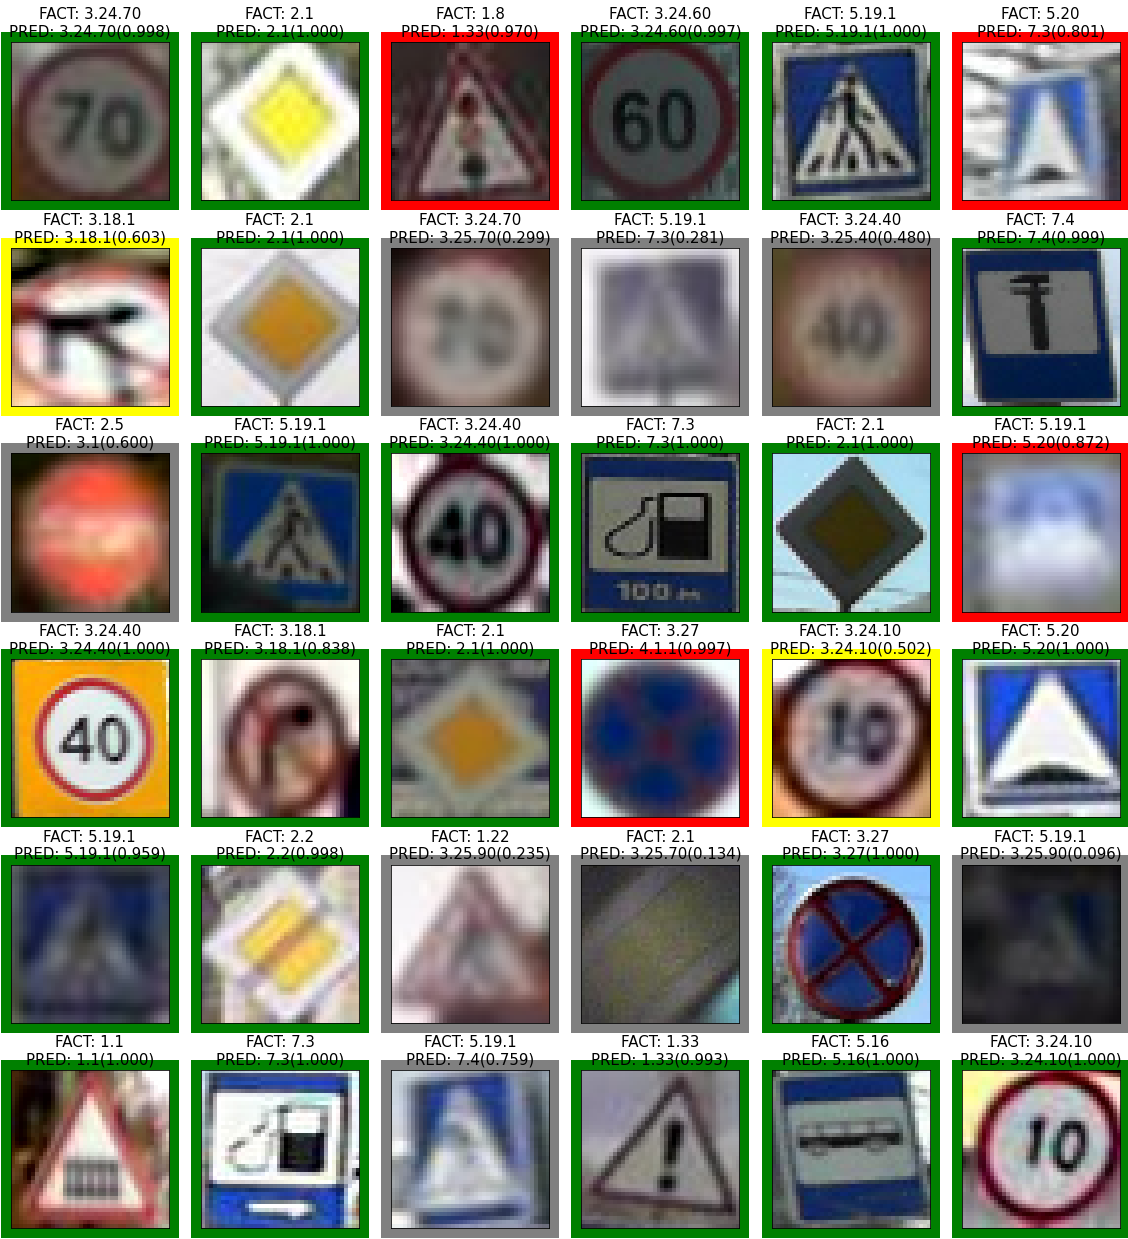

In [28]:
TEMP_DATASET = getNSamplesFromDataSet(test_dataset, 36)

nrows, ncols = 70, 6
fig = plt.figure(figsize = (16,200))

wrongs = 0
model.eval()
CONF_THRES = 0.8

for idx, (img, encoded_label) in enumerate(TEMP_DATASET):
    
    pred = modelDetect(img[None, ...].to(device)).cpu().detach().numpy()
    # pred = nn.Softmax(pred)
    # make img from tensor
    img = torch.Tensor.permute(img, [1, 2, 0]).numpy()   
    
    isPredictionRight, model_pred_sign, target_sign, confidence = checkModelOutAndCompareToTargetLabel(pred,
                                                                                                       encoded_label
                                                                                                      )
    
    ax = fig.add_subplot(nrows, ncols, idx+1)
    ax.patch.set_linewidth('20')
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    if isPredictionRight and confidence > CONF_THRES:
        ax.patch.set_edgecolor('green')
    elif isPredictionRight:
        print('low conf for', [(idx+1) // ncols , (idx+1) % ncols])
        ax.patch.set_edgecolor('yellow')
    else:
        if confidence > CONF_THRES:
            print('mismatch with high conf for', [(idx+1) // ncols , (idx+1) % ncols])
            ax.patch.set_edgecolor('red')
        else:
            print('mismatch for', [(idx+1) // ncols , (idx+1) % ncols])
            ax.patch.set_edgecolor('gray')
        wrongs += 1
        
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect=1)
    
    FACT_SIGN = 'FACT: ' + str(target_sign)
    PRED_SIGN = '\nPRED: ' + str(model_pred_sign)
    CONF = '(%.3f)' % confidence
    
    title = FACT_SIGN + PRED_SIGN + CONF
    title = ax.set_title(title, fontsize=15)
    
print('Accuracy:',  1 - wrongs / len(TEMP_DATASET))
plt.tight_layout()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def getDataForClassificationReport(model, loader):

    model.eval()
    model.to(device)
    
    y_true = []
    y_pred = []
    
    pbar = tqdm(loader,
                total=len(loader),
                position=0,
                leave=True,
                desc='Getting y_true, y_pred for classification ...')
        
    for idx, (img, encoded_label) in enumerate(pbar):
        img = img.to(device)
        pred = model(img).cpu().detach().numpy()

        y_true.extend(encoded_label.detach().numpy())
        y_pred.extend(np.argmax(pred, axis=1))
            
    return y_true, y_pred
            
y_true, y_pred = getDataForClassificationReport(model, test_loader)

In [ ]:
len(y_true)

In [ ]:
len(y_pred)

In [ ]:
set(y_pred) - set(y_true)

In [ ]:
labels = le.inverse_transform(np.unique(np.unique(y_pred)))

print(classification_report(y_true, 
                            y_pred, 
                            target_names=labels
                           ))

In [ ]:
cmat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(32,32))
sns.heatmap(cmat, 
            annot=True, 
            cbar=False, 
            cmap='Paired', fmt="d", 
            xticklabels=labels, 
            yticklabels=labels)

In [ ]:
classwise_acc = cmat.diagonal()/cmat.sum(axis=1) * 100 
cls_acc = pd.DataFrame(
    {'Class_Label':labels,
     'Accuracy': classwise_acc.tolist()
    }, 
    columns = ['Class_Label', 'Accuracy'])
cls_acc.style.format({"Accuracy": "{:,.2f}",}).hide_index().bar(subset=["Accuracy"], color='tomato')